In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

from functions import (plot_DA_week,
                    load_da_market_data)

## Parameters


#### Constants


In [3]:
#Battery Parameters
battery_capacity = 40 #[MWh]
SOC_min = 1 #[Mwh]
charge_rate_min = 0 #[MW]
discharge_rate_min = 0 #[MW]
charge_rate_max = 10 #[MW]
discharge_rate_max = 10 #[MW]
efficiency = 0.99
self_discharge_rate = 0
initial_SOC = 20 #[MWh]

#Market Parameters:
    #DAM:
minimum_bid_DAM = 0.1 #[MW]
granularity_DAM = 1 #hours


#### Model Definitions

In [4]:
#Initialize optimization problem:
MMO = gp.Model("Multi Market Optimization")

Set parameter Username
Set parameter LicenseID to value 2648244
Academic license - for non-commercial use only - expires 2026-04-07


## Data Loading

#### Day-Ahead Auction, (1h granularity)

In [36]:
da_folder = "data/energy-charts_day_ahead"
years_to_load = [2024] # Define the years you want to import, we have from 2015 to 2024.
DA_prices_merged = load_da_market_data(da_folder, years_to_load)
print(DA_prices_merged.head())

clearing_price_DAM = DA_prices_merged['price_eur_mwh'].to_numpy(dtype=float)
print(len(clearing_price_DAM))
timestamps = DA_prices_merged['timestamp']

DAM_horizon = range(len(clearing_price_DAM)) #Define the time horizon based on the length of the loaded data
bidding_slots_DAM = range(10) #arbitrary number for now, to allow for non-uniform biding
side = ["Buy","Sell"]


                  timestamp  price_eur_mwh
0 2023-12-31 23:00:00+00:00          25.97
1 2024-01-01 00:00:00+00:00          21.99
2 2024-01-01 01:00:00+00:00          14.32
3 2024-01-01 02:00:00+00:00          11.37
4 2024-01-01 03:00:00+00:00          11.35
8784


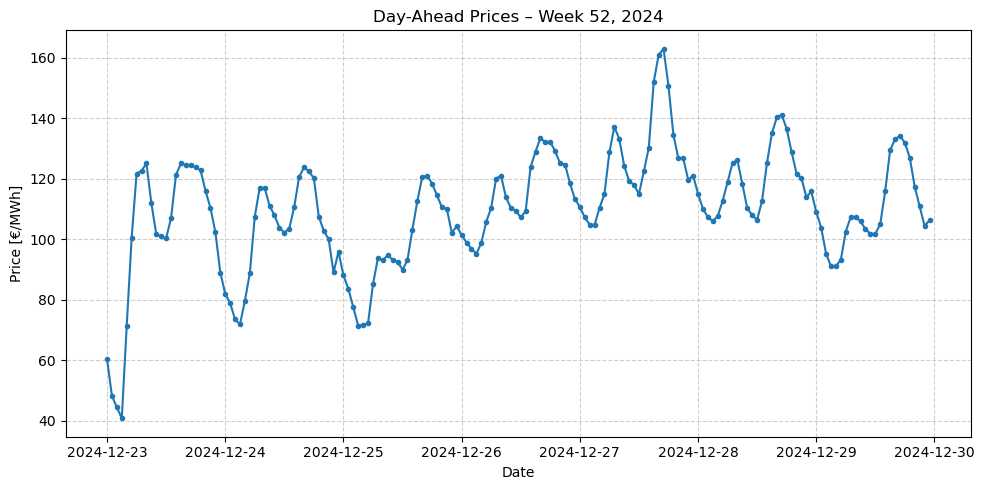

In [37]:
plot_DA_week(DA_prices_merged, year=2024, week=52) #Plot the DA prices for a given week

## Decision Variables

In [ ]:
Charge = MMO.addVars(DAM_horizon, vtype=GRB.CONTINUOUS, lb=charge_rate_min, ub=charge_rate_max, name="Battery_Charge [MW]") 
Discharge = MMO.addVars(DAM_horizon, vtype=GRB.CONTINUOUS, lb=discharge_rate_min, ub=discharge_rate_max, name="Battery_Discharge [MW]")
Charging_Indicator = MMO.addVars(DAM_horizon, vtype=GRB.BINARY, name= "Charging_Indicator") #1 if charging, 0 if discharging

SOC = MMO.addVars(DAM_horizon, vtype=GRB.CONTINUOUS, lb=SOC_min, ub=battery_capacity, name="Battery_State_Of_Charge [MWh]") 

DAM_Bid_Price = MMO.addVars(DAM_horizon, bidding_slots_DAM, side, vtype=GRB.CONTINUOUS, lb=0, name="Day_Ahead_Market_Bid [CHF]")
DAM_Bid_Volume = MMO.addVars(DAM_horizon, bidding_slots_DAM, side, vtype=GRB.CONTINUOUS, lb=0, name="Day_Ahead_Market_Volume [#MW]")
DAM_Bid_Placement = MMO.addVars(DAM_horizon, bidding_slots_DAM, side, vtype=GRB.BINARY, name="Day_Ahead_Market_Bid_Placement")

DAM_Bid_Activation = MMO.addVars(DAM_horizon, bidding_slots_DAM, side, vtype=GRB.BINARY, name="Day_Ahead_Market_Bid_Acceptance")
DAM_Executed_volume = MMO.addVars(DAM_horizon, bidding_slots_DAM, side, vtype=GRB.CONTINUOUS, lb=0, name="Day_Ahead_Market_Executed_Volume [MW]")

## Constraints

In [39]:
#1 - Battery State of Charge Balance 
MMO.addConstr(SOC[0] == initial_SOC)
MMO.addConstr(SOC[max(DAM_horizon)] == initial_SOC) #End the horizon at initial SOC

for t in DAM_horizon[:-1]:
    MMO.addConstr(SOC[t+1] == (1 - self_discharge_rate) * SOC[t] + granularity_DAM * (efficiency * Charge[t] - 1 / efficiency * Discharge[t])) #SOC balance equation

#Day Ahead Market Constraints
for t in DAM_horizon:
    for slot in bidding_slots_DAM:
        #Cannot buy and sell simultaniously in the same bidding slot 
        MMO.addConstr(DAM_Bid_Placement[t, slot, "Buy"] + DAM_Bid_Placement[t, slot, "Sell"] <= 1)
    
        #Market Clearing
        MMO.addGenConstrIndicator(DAM_Bid_Activation[t, slot, "Buy"], True, DAM_Bid_Price[t , slot, "Buy"] >= clearing_price_DAM[t])
        MMO.addGenConstrIndicator(DAM_Bid_Activation[t, slot, "Buy"], False, DAM_Bid_Price[t , slot, "Buy"] <= clearing_price_DAM[t])
        MMO.addConstr(DAM_Bid_Activation[t, slot, "Buy"] <= DAM_Bid_Placement[t, slot, "Buy"])

        MMO.addGenConstrIndicator(DAM_Bid_Activation[t, slot, "Sell"], False, DAM_Bid_Price[t, slot, "Sell"] >= clearing_price_DAM[t])
        MMO.addGenConstrIndicator(DAM_Bid_Activation[t, slot, "Sell"], True, DAM_Bid_Price[t, slot, "Sell"] <= clearing_price_DAM[t])
        MMO.addConstr(DAM_Bid_Activation[t, slot, "Sell"] <= DAM_Bid_Placement[t, slot, "Sell"])

        for s in side:
            #Enfore minimum bidding volume
            MMO.addConstr(DAM_Bid_Placement[t, slot, s] * minimum_bid_DAM <= DAM_Bid_Volume[t, slot, s])
            #Extract Executed Volume 
            MMO.addGenConstrIndicator(DAM_Bid_Activation[t, slot, s], True, DAM_Executed_volume[t, slot, s] == DAM_Bid_Volume[t, slot, s])
            MMO.addGenConstrIndicator(DAM_Bid_Activation[t, slot, s], False, DAM_Executed_volume[t, slot, s] == 0)


for t in DAM_horizon:
    #Link the executed bids to the battery dispatch
    MMO.addConstr(Discharge[t] == quicksum(DAM_Executed_volume[t, slot, "Sell"] for slot in bidding_slots_DAM))
    MMO.addConstr(Charge[t] == quicksum(DAM_Executed_volume[t, slot, "Buy"] for slot in bidding_slots_DAM))

    #Prevent simultanious charging and discharging
    MMO.addGenConstrIndicator(Charging_Indicator[t], True,  Discharge[t] == 0)
    MMO.addGenConstrIndicator(Charging_Indicator[t], False,  Charge[t] == 0)

## Objective Function & Solving

In [40]:
Profit = quicksum(clearing_price_DAM[t] * Discharge[t]*granularity_DAM - clearing_price_DAM[t] * Charge[t]*granularity_DAM for t in DAM_horizon)

#Solve Optimization Problem
MMO.setObjective(Profit, GRB.MAXIMIZE)
MMO.setParam('TimeLimit', 60) 
MMO.optimize()



Set parameter TimeLimit to value 60
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.6.0 24G90)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
TimeLimit  60

Optimize a model with 939893 rows, 3654248 columns and 2248704 nonzeros
Model fingerprint: 0xcd6cb138
Model has 1440576 simple general constraints
  1440576 INDICATOR
Variable types: 2213631 continuous, 1440617 integer (1440617 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e-02, 4e+02]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 2e+01]
  GenCon rhs range [1e-02, 4e+02]
  GenCon coe range [1e+00, 1e+00]

Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 5s
Processing MIP start from previous solve: 0 nodes explored in subMIP, total elapsed time 10s
MIP start from previous solve produced solution with objective 844967 (11.03s)
Loaded MIP sta

## Extract Results

In [41]:
print(f"Maximum Profit: {MMO.ObjVal:.2f} €")
Charge_opt = np.array([Charge[t].X for t in DAM_horizon])
Discharge_opt = np.array([Discharge[t].X for t in DAM_horizon])
SOC_opt = np.array([SOC[t].X for t in DAM_horizon])

Maximum Profit: 844966.58 €


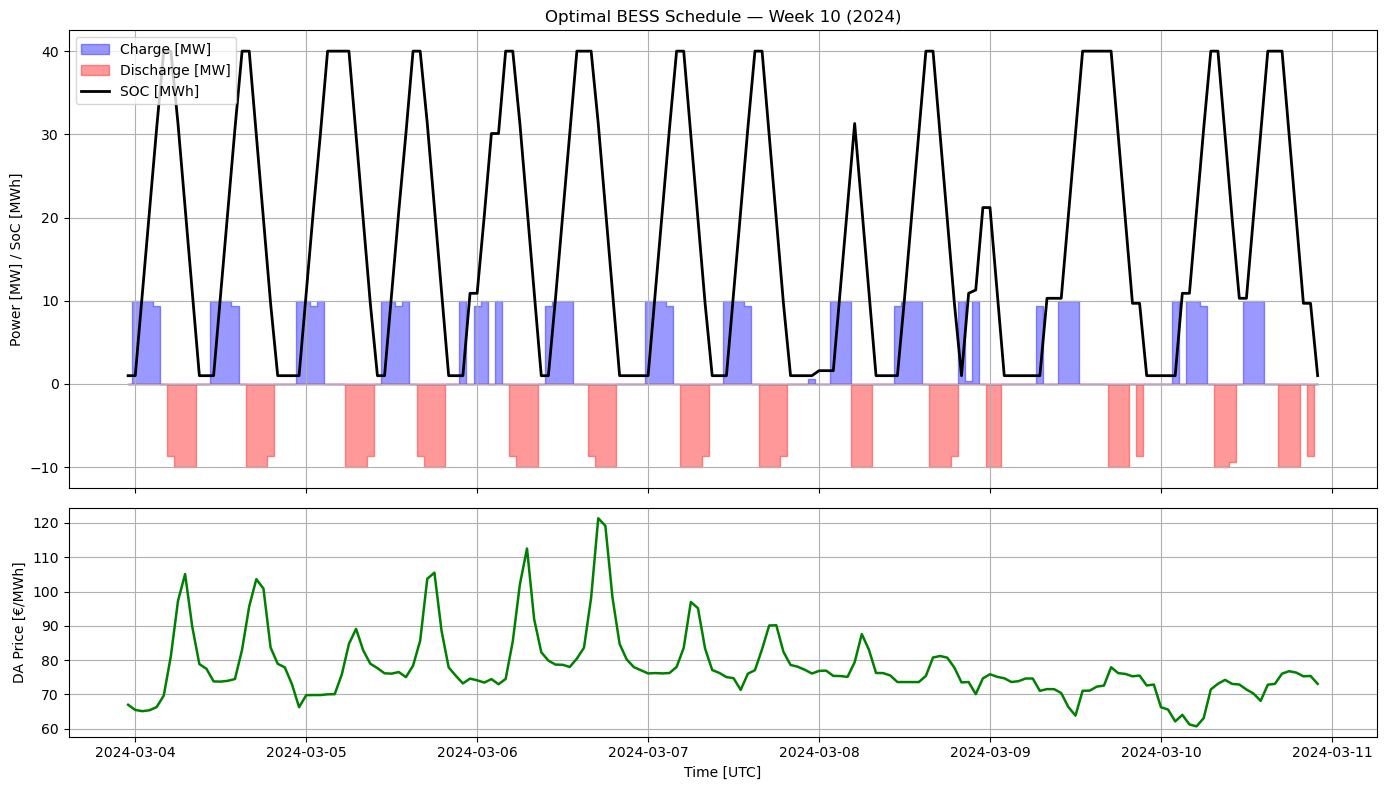

In [43]:
# -------------------------------
# Plot optimal schedule and prices
# -------------------------------
week_number = 10  # Choose the week (1 = first week, etc.)
hours_per_week = 24 * 7
start_idx = (week_number - 1) * hours_per_week
end_idx = start_idx + hours_per_week

time_week = timestamps.iloc[start_idx:end_idx]
Charge_week = Charge_opt[start_idx:end_idx]
Discharge_week = Discharge_opt[start_idx:end_idx]
SOC_week = SOC_opt[start_idx:end_idx]
Price_week = clearing_price_DAM[start_idx:end_idx]

fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- Plot 1: Battery operation ---
axs[0].fill_between(time_week, 0, Charge_week, step='mid', alpha=0.4, color='blue', label='Charge [MW]')
axs[0].fill_between(time_week, 0, -Discharge_week, step='mid', alpha=0.4, color='red', label='Discharge [MW]')
axs[0].plot(time_week, SOC_week, color='black', linewidth=2, label='SOC [MWh]')
axs[0].set_ylabel("Power [MW] / SoC [MWh]")
axs[0].legend(loc='upper left')
axs[0].grid(True)
axs[0].set_title(f"Optimal BESS Schedule — Week {week_number} ({timestamps.dt.year.iloc[1]})")

# --- Plot 2: DA Prices ---
axs[1].plot(time_week, Price_week, color='green', linewidth=1.8)
axs[1].set_ylabel("DA Price [€/MWh]")
axs[1].grid(True)
axs[1].set_xlabel("Time [UTC]")

plt.tight_layout()
plt.show()